# Multilayer Perceptron (MLP)

In [1]:
# import external modules
import sys, os
ROOT_PATH = os.path.abspath(".").split("src")[0]
module_path = os.path.abspath(os.path.join(ROOT_PATH+"/src/utils/"))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc 
from tabulate import tabulate

import keras
from keras import layers, regularizers, Input, Model
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import backend as K

import tensorflow as tf
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import functions as f
import dl_functions as dlf
from generators import batch_generator

Using TensorFlow backend.


In [2]:
# configure matplotlib params and plotting
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

rc('figure', figsize=(12,6))
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc('axes', labelsize=13, titlesize=14)
rc('legend', fontsize=14, handlelength=2)
rc('font', family='serif')

SEED=100
np.random.seed(SEED)
tf.set_random_seed(SEED)

## Read and load data

In [3]:
df_train, df_valid, df_test = f.load_data()
#df_train, df_valid, df_test = f.load_data(dummy_data=True, dummy_obs=5000)
stats, ts, ts_train, ts_valid, ts_test = f.load_metadata()

# split datasets into features and targets
x_train, y_train = f.split_dataset(df_train.values, delay=1)
x_valid, y_valid = f.split_dataset(df_valid.values, delay=1)
x_test, y_test = f.split_dataset(df_test.values, delay=1)

# metadata
target_tags = df_train.columns.values[:3]
feature_tags = df_train.columns.values[3:]
target_stds = stats.loc[target_tags,"Std"].values

## Model evaluation functions

In [4]:
def evaluate_errors(errors, stds = stats.loc[target_tags, "Std"].values):
    
    maes = pd.DataFrame(errors, columns=["FT", "TT", "PT"]).mean().values
    maes_unstd = maes * stds
    
    indexes = ["FT", "TT", "PT"]
    cols = ["MAE (std)", "MAE (unstd)"]
    data = np.column_stack([maes, maes_unstd])
    err_df = pd.DataFrame(data, index=indexes, columns=cols)
    err_df.loc["Avg"] = err_df.mean()

    str_table = tabulate(err_df, headers='keys', tablefmt='psql', floatfmt='.5f')

    return_dict = {
        'df': err_df,
        'str_table': str_table,
        'maes': maes,
        'maes_unstd': maes_unstd,
    }
    
    return return_dict

In [5]:
def evaluate_mlp(model_func, train_tuple, valid_tuple, test_tuple, name, 
                 epochs=30, iterations=5, batch_size=128, n_pred=30, make_plots=True):
    
    root_path = os.path.abspath(".").split("src")[0]
    model_folder = root_path + "models/{0}/{1}/".format(name,epochs)
    if not os.path.exists(model_folder):
        print("Creating directory", model_folder)
        os.makedirs(model_folder)
        
    models = []
    histories = []
    val_dfs = []
    test_dfs = []
    
    best_mae = 500
    best_model = None
    best_history = None
    
    for i in range(iterations):
        model = model_func(train_tuple[0].shape, train_tuple[1].shape)
        
        print("Training model {0} #{1}".format(name, i+1))
        weights_checkpoint = model_folder + "weights_{0}.h5".format(i+1)
        
        callbacks = [
            ModelCheckpoint(
                filepath=weights_checkpoint, monitor='val_loss',verbose=1,
                save_weights_only=True,save_best_only=True
            ),
            
            keras.callbacks.ReduceLROnPlateau(
                monitor = 'loss', factor = 0.5, patience = 5, verbose = 1, min_lr=1e-5,
            )
        ]
    
        model.compile(loss='mae', optimizer=keras.optimizers.Adam(lr=1e-3))
        history = model.fit(train_tuple[0], train_tuple[1],
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=valid_tuple,
                            callbacks=callbacks)

        if make_plots: dlf.plot_history(history)

        # load the weights at the best checkpoint
        model.load_weights(weights_checkpoint)
    
        # Performance on validation data
        val_df = dlf.get_model_maes(model, valid_tuple[0], valid_tuple[1], 
                                    target_stds, n_predictions=n_pred, input_dim=2)['df']

        # Performance on testing data
        test_df = dlf.get_model_maes(model, test_tuple[0], test_tuple[1],
                                     target_stds, n_predictions=n_pred, input_dim=2)['df']
                
        models.append(model)
        histories.append(history)
        val_dfs.append(val_df)
        test_dfs.append(test_df)
        
        avg_mae = val_df["MAE (std)"]["Avg"]
        print("AVG MAE", avg_mae)
        if avg_mae < best_mae:
            best_mae = avg_mae
            best_model = model
            best_history = history
            
            best_model.save(model_folder + "model.h5")
            best_model.save_weights(model_folder + "weights.h5")
    
    val_avgs = sum(val_dfs) / len(val_dfs)
    test_avgs = sum(test_dfs) / len(test_dfs)
    
    val_str_table = tabulate(val_avgs, headers='keys', tablefmt='psql', floatfmt='.5f')
    print(" **** VALIDATION **** ")
    print(val_str_table)
    
    test_str_table = tabulate(test_avgs, headers='keys', tablefmt='psql', floatfmt='.5f')
    print(" **** TEST **** ")
    print(test_str_table)
    
    val_dict = {
        'df': val_avgs,
        'str_table': val_str_table
    }
    
    test_dict = {
        'df': test_avgs,
        'str_table': test_str_table
    }
    
    return_dict = {
        'model': best_model,
        'history': best_history,
        'models': models, 
        'histories': histories,
        'validation': val_dict,
        'test': test_dict,
    }
    
    # save dictionary to model folder
    f.save_pickle(obj=return_dict, fpath=model_folder+"model_dict.pkl")
    
    return return_dict

# MLP 1: Single hidden layer with 128 nodes

In [45]:
def mlp_128(x_shape, y_shape):
    
    input_layer = Input(shape=(x_shape[-1],))
    layer_1 = layers.Dense(128, activation='relu')(input_layer)
    layer_2 = layers.Dropout(0.3)(layer_1, training=True)
    output_layer = layers.Dense(y_shape[-1])(layer_2)
    
    model = Model(input_layer, output_layer)
    return model

Training model mlp_128 #1
Train on 53210 samples, validate on 17736 samples
Epoch 1/50
53210/53210 [==============================] - 1s 13us/step - loss: 0.5406 - val_loss: 0.5473

Epoch 00001: val_loss improved from inf to 0.54730, saving model to /Users/hreiten/Documents/Universitet/NTNU/master-thesis/models/mlp_128/50/weights_1.h5
Epoch 2/50
53210/53210 [==============================] - 1s 9us/step - loss: 0.4871 - val_loss: 0.5277

Epoch 00002: val_loss improved from 0.54730 to 0.52770, saving model to /Users/hreiten/Documents/Universitet/NTNU/master-thesis/models/mlp_128/50/weights_1.h5
Epoch 3/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4783 - val_loss: 0.5217

Epoch 00003: val_loss improved from 0.52770 to 0.52171, saving model to /Users/hreiten/Documents/Universitet/NTNU/master-thesis/models/mlp_128/50/weights_1.h5
Epoch 4/50
53210/53210 [==============================] - 1s 14us/step - loss: 0.4752 - val_loss: 0.5226

Epoch 00004: val_loss did not

53210/53210 [==============================] - 0s 8us/step - loss: 0.4630 - val_loss: 0.5133

Epoch 00045: val_loss did not improve from 0.50940
Epoch 46/50
53210/53210 [==============================] - 0s 8us/step - loss: 0.4631 - val_loss: 0.5139

Epoch 00046: val_loss did not improve from 0.50940
Epoch 47/50
53210/53210 [==============================] - 0s 8us/step - loss: 0.4621 - val_loss: 0.5142

Epoch 00047: val_loss did not improve from 0.50940
Epoch 48/50
53210/53210 [==============================] - 1s 10us/step - loss: 0.4622 - val_loss: 0.5118

Epoch 00048: val_loss did not improve from 0.50940
Epoch 49/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4629 - val_loss: 0.5134

Epoch 00049: val_loss did not improve from 0.50940

Epoch 00049: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 50/50
53210/53210 [==============================] - 1s 10us/step - loss: 0.4625 - val_loss: 0.5147

Epoch 00050: val_loss did not improve 

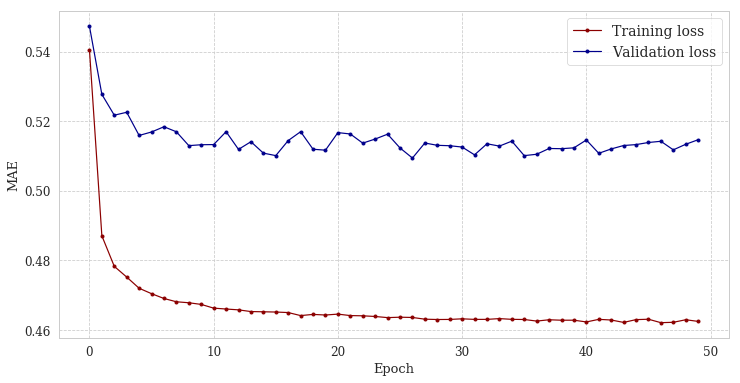

AVG MAE 0.5107336102889074
 **** VALIDATION **** 
+-----+-------------+---------------+----------------+-----------------+
|     |   MAE (std) |   MAE (unstd) |   Expect. Mean |   Expect. Stdev |
|-----+-------------+---------------+----------------+-----------------|
| FT  |     0.67452 |    2277.62791 |       -0.33720 |         0.18495 |
| TT  |     0.33269 |       0.32489 |        1.28915 |         0.18489 |
| PT  |     0.52499 |       0.12993 |       -0.06510 |         0.17111 |
| Avg |     0.51073 |     759.36091 |        0.29562 |         0.18032 |
+-----+-------------+---------------+----------------+-----------------+
 **** TEST **** 
+-----+-------------+---------------+----------------+-----------------+
|     |   MAE (std) |   MAE (unstd) |   Expect. Mean |   Expect. Stdev |
|-----+-------------+---------------+----------------+-----------------|
| FT  |     0.61790 |    2086.45852 |       -0.47560 |         0.20408 |
| TT  |     0.30229 |       0.29520 |        1.69149 |   

In [46]:
K.clear_session()

name = "mlp_128"
iterations = 1
batch_size = 256
epochs = 50
n_pred = 300

mlp_128_dict = evaluate_mlp(mlp_128, 
                            train_tuple=(x_train, y_train), 
                            valid_tuple=(x_valid, y_valid), 
                            test_tuple=(x_test, y_test), 
                            name=name, 
                            epochs=epochs,
                            iterations=iterations,
                            n_pred=n_pred,
                            batch_size=batch_size)

# MLP 2: Single hidden layer with 1024 nodes

In [43]:
def mlp_1024(x_shape, y_shape):
    
    input_layer = Input(shape=(x_shape[-1],))
    layer_1 = layers.Dense(1024, activation='relu', kernel_initializer = 'random_uniform')(input_layer)
    layer_2 = layers.Dropout(0.3)(layer_1, training=True)

    output_layer = layers.Dense(y_shape[-1])(layer_2)
    
    model = Model(input_layer, output_layer)
    return model

Training model mlp_1024 #1
Train on 53210 samples, validate on 17736 samples
Epoch 1/50
53210/53210 [==============================] - 2s 34us/step - loss: 0.4859 - val_loss: 0.4973

Epoch 00001: val_loss improved from inf to 0.49726, saving model to /Users/hreiten/Documents/Universitet/NTNU/master-thesis/models/mlp_1024/50/weights_1.h5
Epoch 2/50
53210/53210 [==============================] - 2s 30us/step - loss: 0.4602 - val_loss: 0.5021

Epoch 00002: val_loss did not improve from 0.49726
Epoch 3/50
53210/53210 [==============================] - 2s 29us/step - loss: 0.4560 - val_loss: 0.5004

Epoch 00003: val_loss did not improve from 0.49726
Epoch 4/50
53210/53210 [==============================] - 2s 30us/step - loss: 0.4536 - val_loss: 0.5082

Epoch 00004: val_loss did not improve from 0.49726
Epoch 5/50
53210/53210 [==============================] - 2s 30us/step - loss: 0.4522 - val_loss: 0.5049

Epoch 00005: val_loss did not improve from 0.49726
Epoch 6/50
53210/53210 [=========

53210/53210 [==============================] - 2s 45us/step - loss: 0.4417 - val_loss: 0.4948

Epoch 00048: val_loss did not improve from 0.48911
Epoch 49/50
53210/53210 [==============================] - 2s 41us/step - loss: 0.4414 - val_loss: 0.4973

Epoch 00049: val_loss did not improve from 0.48911
Epoch 50/50
53210/53210 [==============================] - 2s 34us/step - loss: 0.4417 - val_loss: 0.4981

Epoch 00050: val_loss did not improve from 0.48911


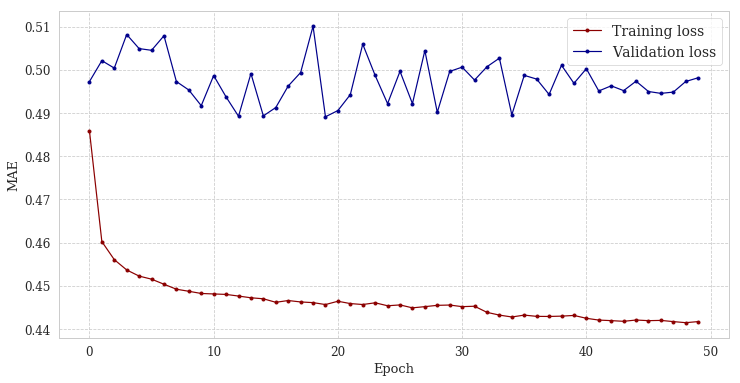

AVG MAE 0.48937126252641966
 **** VALIDATION **** 
+-----+-------------+---------------+----------------+-----------------+
|     |   MAE (std) |   MAE (unstd) |   Expect. Mean |   Expect. Stdev |
|-----+-------------+---------------+----------------+-----------------|
| FT  |     0.64916 |    2191.99063 |       -0.33046 |         0.12610 |
| TT  |     0.31257 |       0.30524 |        1.27085 |         0.09613 |
| PT  |     0.50639 |       0.12532 |       -0.03536 |         0.09990 |
| Avg |     0.48937 |     730.80706 |        0.30168 |         0.10737 |
+-----+-------------+---------------+----------------+-----------------+
 **** TEST **** 
+-----+-------------+---------------+----------------+-----------------+
|     |   MAE (std) |   MAE (unstd) |   Expect. Mean |   Expect. Stdev |
|-----+-------------+---------------+----------------+-----------------|
| FT  |     0.58955 |    1990.72863 |       -0.49522 |         0.13878 |
| TT  |     0.26375 |       0.25756 |        1.66888 |  

In [44]:
K.clear_session()

name = "mlp_1024"
iterations = 1
batch_size = 256
epochs = 50
n_pred = 300

mlp_1024_dict = evaluate_mlp(mlp_1024, 
                             train_tuple=(x_train, y_train), 
                             valid_tuple=(x_valid, y_valid), 
                             test_tuple=(x_test, y_test), 
                             name=name, 
                             epochs=epochs,
                             iterations=iterations,
                             n_pred=n_pred,
                             batch_size=batch_size)

# MLP 3: "ResNets"

Inspired by ResNets, but with batch normalization after each stack, and ReLU activation after each layer

In [60]:
def mlp_resnet(x_shape, y_shape):
    input_layer = Input(shape=(None, x_shape[-1]))
    
    layer_1 = layers.Dense(128, activation = 'relu', kernel_initializer='glorot_uniform')(input_layer)
    layer_2 = layers.Dense(512, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_1)
    layer_3 = layers.Dense(512, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_2)
    layer_4 = layers.Dense(512, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_3)
    layer_5 = layers.BatchNormalization()(layer_4)
    residual_1 = layers.Dense(512, use_bias = False)(layer_1)
    layer_5b = layers.add([layer_5, residual_1])
    layer_6 = layers.Dropout(0.5)(layer_5b, training=True)

    layer_7 = layers.Dense(256, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_6)
    layer_8 = layers.Dense(256, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_7)
    layer_9 = layers.Dense(256, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_8)
    layer_10 = layers.BatchNormalization()(layer_9)
    residual_2 = layers.Dense(256, use_bias = False)(layer_6)
    residual_2x = layers.Dense(256, use_bias = False)(layer_1)
    layer_10b = layers.add([layer_10, residual_2, residual_2x])
    layer_11 = layers.Dropout(0.45)(layer_10b, training=True)

    layer_12 = layers.Dense(256, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_11)
    layer_13 = layers.Dense(256, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_12)
    layer_14 = layers.Dense(256, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_13)
    layer_15 = layers.BatchNormalization()(layer_14)
    #residual_3 = layers.Dense(256, use_bias = False)(layer_11)
    residual_3x = layers.Dense(256, use_bias = False)(layer_1)
    layer_15b = layers.add([layer_15, layer_11, residual_3x])
    layer_16 = layers.Dropout(0.45)(layer_15b, training=True)

    layer_17 = layers.Dense(128, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_16)
    layer_18 = layers.Dense(128, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_17)
    layer_19 = layers.Dense(128, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_18)
    layer_20 = layers.BatchNormalization()(layer_19)
    residual_4 = layers.Dense(128, use_bias = False)(layer_16)
    residual_4x = layers.Dense(128, use_bias = False)(layer_1)
    layer_20b = layers.add([layer_20, residual_4, residual_4x])
    layer_21 = layers.Dropout(0.4)(layer_20b, training=True)

    layer_22 = layers.Dense(128, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_21)
    layer_23 = layers.Dense(128, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_22)
    layer_24 = layers.Dense(128, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_23)
    layer_25 = layers.BatchNormalization()(layer_24)
    #residual_5 = layers.Dense(128, use_bias = False)(layer_21)
    residual_5x = layers.Dense(128, use_bias = False)(layer_1)
    layer_25b = layers.add([layer_25, layer_21, residual_5x])
    layer_26 = layers.Dropout(0.4)(layer_25b, training=True)

    layer_27 = layers.Dense(64, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_26)
    layer_28 = layers.Dense(64, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_27)
    layer_29 = layers.Dense(64, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_28)
    layer_30 = layers.BatchNormalization()(layer_29)
    residual_6 = layers.Dense(64, use_bias = False)(layer_26)
    residual_6x = layers.Dense(64, use_bias = False)(layer_1)
    layer_30b = layers.add([layer_30, residual_6, residual_6x])
    layer_31 = layers.Dropout(0.3)(layer_30b, training=True)
    
    output_layer = layers.Dense(y_shape[-1])(layer_31)
    
    model = Model(input_layer, output_layer)
    return model

In [61]:
K.clear_session()

n_predictions = 50 
lookback = 60
batch_size = 256
epochs = 30
name = "mlp_resnet"

mlp_resnet_dict = evaluate_model(model_func=mlp_resnet,
                               train_tuple=(x_train, y_train),
                               valid_tuple=(x_valid, y_valid),
                               test_tuple=(x_test, y_test),
                               name=name,
                               target_stds=target_stds,
                               target_tags=target_tags,
                               generator_func=batch_generator,
                               n_predictions=n_predictions,
                               lookback=lookback,
                               batch_size=batch_size,
                               epochs=epochs,
                               makeplots=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 6)      0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, None, 128)    896         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, None, 512)    66048       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, None, 512)    262656      dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

Epoch 1/30
 41/207 [====>.........................] - ETA: 9:32 - loss: 2.2113

KeyboardInterrupt: 

# Final results

In [8]:
model = dlf.load_keras_model(ROOT_PATH + "models/mlp_1024/50/")
mlp_dict = dlf.evaluate_trained_model(model, (x_valid, y_valid), (x_test, y_test), 
                                      target_stds=target_stds, n_pred=300, input_dim=2)

In [9]:
# Error summary
dicts = [mlp_dict]
columns=["FT", "TT", "PT", "Avg"]
index = ["MLP"]
summary, tex = dlf.get_df_from_dicts(dicts, columns, index)
print(tex)
print(summary)
print()

# Uncertainty summary
columns=["MAE", "Exp. Mean", "Exp. Std"]
index = ["MLP"]
levels = ["FT","TT","PT","Avg"]
mlp_unc, tex_unc = dlf.get_uncertainty_df_from_dicts(dicts, columns, index, levels)
print(tex_unc)
print(mlp_unc)
print()

\begin{tabular}{lcccccccc}
\toprule
{} & \multicolumn{4}{c}{Validation} & \multicolumn{4}{c}{Test} \\
{} &         FT &      TT &      PT &     Avg &      FT &      TT &      PT &     Avg \\
\midrule
\textbf{MLP} &     0.6492 &  0.3126 &  0.5063 &  0.4894 &  0.5895 &  0.2638 &  0.4919 &  0.4484 \\
\bottomrule
\end{tabular}

    Validation                            Test                        
            FT      TT      PT     Avg      FT      TT      PT     Avg
MLP     0.6492  0.3126  0.5063  0.4894  0.5895  0.2638  0.4919  0.4484

\begin{tabular}{llcccccc}
\toprule
    &     & \multicolumn{3}{c}{Validation} & \multicolumn{3}{c}{Test} \\
    &     &        MAE & Exp. Mean & Exp. Std &     MAE & Exp. Mean & Exp. Std \\
\midrule
\multirow{4}{*}{\textbf{MLP}} & \textbf{FT} &     0.6492 &   -0.3305 &   0.1262 &  0.5895 &   -0.4954 &   0.1388 \\
    & \textbf{TT} &     0.3126 &    1.2708 &   0.0961 &  0.2638 &    1.6688 &   0.1142 \\
    & \textbf{PT} &     0.5063 &   -0.0354 &   0.1000 &

#### Export results

In [10]:
path = ROOT_PATH + "models/dataframes/"
summary.to_pickle(path + "mlp_summary_df.pkl")
mlp_unc.to_pickle(path + "mlp_uncertainty_df.pkl")